<a href="https://colab.research.google.com/github/Sachin270/CMLAssignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ls /content/drive/'MyDrive'/'Colab Notebooks'/

'Assignment2 (1).ipynb'       Image_classification_data.zip
 Assignment2.ipynb	      patch_images
 Assignment2_s3714805.ipynb   Untitled0.ipynb
 CMLAssignment2-main.zip      Untitled2.ipynb
 data_labels_extraData.csv   'Untitled8 (1).ipynb'
 data_labels_mainData.csv     Untitled8.ipynb


In [4]:
!cp /content/drive/'MyDrive'/'Colab Notebooks'/'Image_classification_data.zip' .
!unzip -q -o 'Image_classification_data.zip'
!rm 'Image_classification_data.zip'
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.layers import Dense
import tensorflow as tf

In [6]:
data = pd.read_csv('./data_labels_mainData.csv')
OUTPUT_CLASSES = 4
data.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

# New Section

In [ ]:
data.groupby('cellTypeName').agg('count')

,InstanceID,patientID,ImageName,cellType,isCancerous
cellTypeName,,,,,
epithelial,4079,4079,4079,4079,4079
fibroblast,1888,1888,1888,1888,1888
inflammatory,2543,2543,2543,2543,2543
others,1386,1386,1386,1386,1386


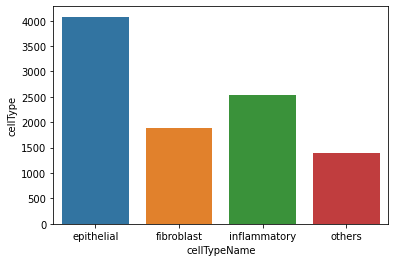

In [ ]:
sns.barplot(x=data.groupby('cellTypeName').agg('count').index, 
            y='cellType',
            data=data.groupby('cellTypeName').agg('count'))

In [ ]:
data.groupby('isCancerous').agg('count')

,InstanceID,patientID,ImageName,cellTypeName,cellType
isCancerous,,,,,
0,5817,5817,5817,5817,5817
1,4079,4079,4079,4079,4079


In [ ]:
sns.barplot(x=mergeData.groupby('isCancerous').agg('count').index, 
            y='cellType', 
            data=data.groupby('isCancerous').agg('count'))

In [ ]:
data.groupby(['cellTypeName', 'isCancerous']).agg('count')

,,InstanceID,patientID,ImageName,cellType
cellTypeName,isCancerous,,,,
epithelial,1,4079,4079,4079,4079
fibroblast,0,1888,1888,1888,1888
inflammatory,0,2543,2543,2543,2543
others,0,1386,1386,1386,1386


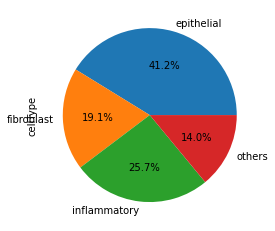

In [ ]:
data.groupby('cellTypeName').agg('count').cellType.plot.pie(autopct="%.1f%%")

In [7]:
extraData = pd.read_csv('data_labels_extraData.csv')
extraData.columns

Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous'], dtype='object')

In [8]:
mergedData = pd.concat([data[["InstanceID", "patientID", "ImageName", "isCancerous"]], extraData])

In [9]:
OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(mergedData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [10]:
train_data['Class'] = train_data['isCancerous'].astype('str')
val_data['Class'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [11]:

reg_lambda = 0.0001
modelCancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [12]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])
    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")                                                  
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim([0, 1])
    plt.show()

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
 monitor='val_categorical_accuracy', 
 verbose=1,
 patience=20,
 mode='max',
 restore_best_weights=True)

In [ ]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [ ]:
historyCancerous = modelCancerous.fit(train_generator, validation_data = validation_generator,callbacks= [early_stopping], epochs=50)

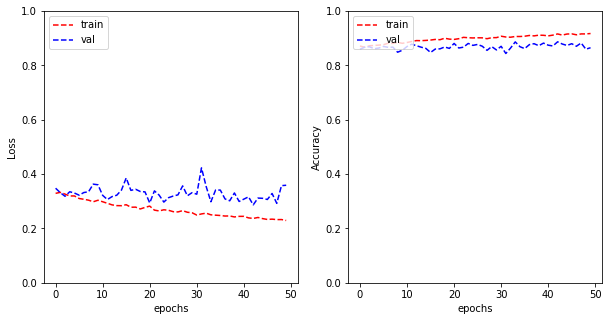

In [ ]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['categorical_accuracy'], historyCancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [14]:
reg_lambda = 0.00001

modelCancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same',  
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax'),
])

In [15]:
modelCancerous.compile(tf.keras.optimizers.Adam(learning_rate=0.00001,name="Adam"),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [16]:
historyCancerous = modelCancerous.fit(train_generator, validation_data = validation_generator, callbacks=[early_stopping], epochs=50)

Epoch 1/50
451/451 [==============================] - 44s 28ms/step - loss: 0.6419 - categorical_accuracy: 0.6504 - val_loss: 0.6186 - val_categorical_accuracy: 0.6573
Epoch 2/50
451/451 [==============================] - 12s 26ms/step - loss: 0.5554 - categorical_accuracy: 0.7106 - val_loss: 0.5357 - val_categorical_accuracy: 0.7194
Epoch 3/50
451/451 [==============================] - 12s 26ms/step - loss: 0.4614 - categorical_accuracy: 0.7887 - val_loss: 0.4369 - val_categorical_accuracy: 0.7912
Epoch 4/50
451/451 [==============================] - 12s 26ms/step - loss: 0.4408 - categorical_accuracy: 0.8011 - val_loss: 0.4339 - val_categorical_accuracy: 0.7897
Epoch 5/50
451/451 [==============================] - 12s 26ms/step - loss: 0.4369 - categorical_accuracy: 0.8011 - val_loss: 0.4047 - val_categorical_accuracy: 0.8148
Epoch 6/50
451/451 [==============================] - 12s 26ms/step - loss: 0.4252 - categorical_accuracy: 0.8046 - val_loss: 0.3977 - val_categorical_accuracy:

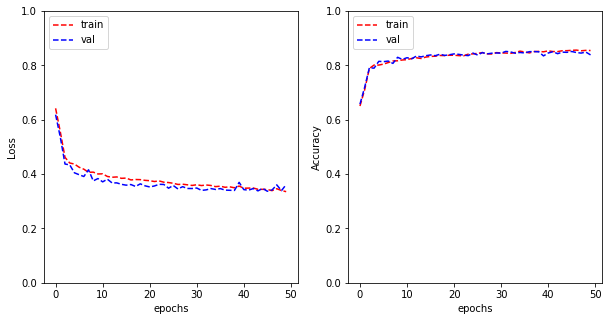

In [17]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['categorical_accuracy'], historyCancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 1
                                                                       
for x,y in validation_generator:
        y_hat = modelCancerous.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Confusion Matrix ", confusion_matrix(y_all, y_hat_all))

Accuracy score:  0.8552859857351361
F1 score:  0.8357058444039311
[[65391  6238]
 [ 9527 27783]]


In [18]:
modelCancerous.save("modelCancerous")

INFO:tensorflow:Assets written to: modelCancerous/assets


In [19]:
## Only on colab
# Change according to your directory structure
!cp -R ./modelCancerous/content/drive/'My Drive'/'Colab Notebooks'      

cp: missing destination file operand after './modelCancerous/content/drive/My Drive/Colab Notebooks'
Try 'cp --help' for more information.


In [ ]:
modelCancerous.summary()

In [20]:
from tensorflow import keras
modelCelltype = keras.models.load_model('/content/modelCancerous')

In [ ]:
modelCelltype.summary()

In [21]:
modelCelltype.pop()

In [22]:
modelCelltype.add(Dense(4, activation='softmax'))

In [ ]:
modelCelltype.summary()

In [ ]:
modelCelltype = modelCancerous

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./data_labels_mainData.csv')

OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [24]:
train_data['Class'] = train_data['cellType'].astype('str')
val_data['Class'] = val_data['cellType'].astype('str')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="Class",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [25]:
modelCelltype.compile(tf.keras.optimizers.Adam(learning_rate=0.0001,name="adam"),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(
 monitor='val_sparse_categorical_accuracy', 
 verbose=1,
 patience=20,
 mode='max',
 restore_best_weights=True)

In [ ]:
class_weight = {0: 1.,1: 2.,2: 2., 3: 1.}

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [ ]:
shavalidation_generator.classes

In [27]:
historyCancerous = modelCelltype.fit(train_generator, validation_data = validation_generator, callbacks=[early_stopping], epochs=50)

Epoch 1/50
220/220 [==============================] - 7s 28ms/step - loss: 1.0193 - sparse_categorical_accuracy: 0.5685 - val_loss: 0.8370 - val_sparse_categorical_accuracy: 0.6842
Epoch 2/50
220/220 [==============================] - 6s 25ms/step - loss: 0.8800 - sparse_categorical_accuracy: 0.6550 - val_loss: 0.7789 - val_sparse_categorical_accuracy: 0.6943
Epoch 3/50
220/220 [==============================] - 6s 26ms/step - loss: 0.8501 - sparse_categorical_accuracy: 0.6781 - val_loss: 0.7500 - val_sparse_categorical_accuracy: 0.7054
Epoch 4/50
220/220 [==============================] - 6s 25ms/step - loss: 0.8049 - sparse_categorical_accuracy: 0.6901 - val_loss: 0.7423 - val_sparse_categorical_accuracy: 0.7024
Epoch 5/50
220/220 [==============================] - 6s 25ms/step - loss: 0.7945 - sparse_categorical_accuracy: 0.6877 - val_loss: 0.7424 - val_sparse_categorical_accuracy: 0.6993
Epoch 6/50
220/220 [==============================] - 6s 25ms/step - loss: 0.7969 - sparse_cate

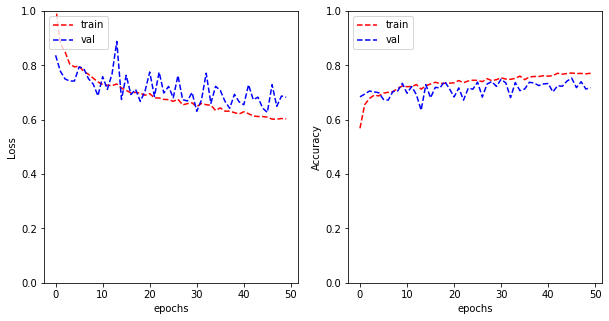

In [28]:
plot_learning_curve(historyCancerous.history['loss'], historyCancerous.history['val_loss'], 
                    historyCancerous.history['sparse_categorical_accuracy'], historyCancerous.history['val_sparse_categorical_accuracy'], 
                    metric_name='Accuracy')

In [29]:
# setup data some placeholders
batch_size_ = 1
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 1

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = modelCelltype.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        # y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size_:
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print("Confusion Matrix ")
print(confusion_matrix(y_all, y_hat_all))
print("Classicification Report")
print(classification_report(y_all, y_hat_all))

Accuracy score:  0.717814484426973
F1 score:  0.655289697089636
Confusion Matrix 
[[ 8871   400   507   429]
 [ 2030 10114   510   934]
 [ 3900   904 16824    27]
 [ 2429  2354   507  2172]]
              precision    recall  f1-score   support

         0.0       0.51      0.87      0.65     10207
         1.0       0.73      0.74      0.74     13588
         2.0       0.92      0.78      0.84     21655
         3.0       0.61      0.29      0.39      7462

    accuracy                           0.72     52912
   macro avg       0.69      0.67      0.66     52912
weighted avg       0.75      0.72      0.71     52912



Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_VGG_2.evaluate(test_generator)

1980/1980 [==============================] - 9s 4ms/step - loss: 1.5789 - sparse_categorical_accuracy: 0.7283


[1.578864574432373, 0.7282828092575073]

In [ ]:
model_VGG_3.optimizer.get_config()